# 1. Install Dependencies and Setup

In [7]:
%pip install tensorflow 
%pip install tensorflow-gpu 
%pip install opencv-python 
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.15.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Using cached tensorflow_macos-2.15.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.10.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.25.2-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.wh

In [9]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      2.1.0
aiofiles                     23.1.0
aiohttp                      3.8.4
aiosignal                    1.3.1
altair                       5.0.1
altgraph                     0.17.2
anyio                        3.6.2
appnope                      0.1.3
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.2
attrs                        22.2.0
Babel                        2.14.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.3
cachetools                   5.3.2
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.6
co

In [10]:
import tensorflow as tf
import os

/Users/spangilinan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [22]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [17]:
data_dir = 'd_data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [20]:
#testing the path of a particular image
img = cv2.imread(os.path.join('d_data', 'VeryMildDemented', '/Users/spangilinan/Desktop/Alzheimer_s Dataset/test/VeryMildDemented/26 (45).jpg'))

In [21]:
#testing the shape of a particular image)
img.shape

(208, 176, 3)

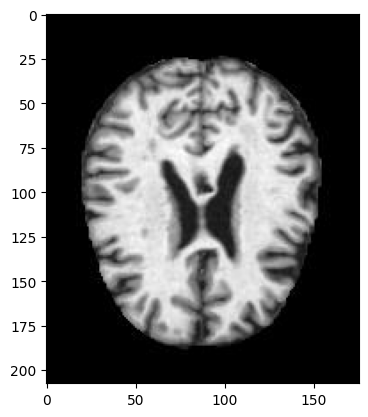

In [24]:
plt.imshow(img)
plt.show()

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [552]:
#using Keras utilities to load the data
data = tf.keras.utils.image_dataset_from_directory('d_data', batch_size=256)
#started with a batch size of 32, but changed it to 64 to accomodate for the large quantity of images
#upgraded batch size in hopes of improving accuracy

Found 1279 files belonging to 4 classes.


In [553]:
data_iterator = data.as_numpy_iterator()

In [554]:
batch = data_iterator.next()

In [555]:
#images represented as numpy arrays
batch[0].shape

(256, 256, 256, 3)

In [556]:
batch[1]
#due to my untrained eyes, I was unable to lable the classes of images below solely based on number assingment

array([3, 0, 1, 0, 3, 3, 3, 3, 3, 2, 0, 0, 2, 2, 2, 3, 3, 3, 0, 2, 2, 2,
       2, 3, 2, 2, 2, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 0, 2, 2,
       2, 2, 0, 2, 2, 3, 3, 2, 2, 3, 3, 0, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 3,
       0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 3, 0, 3, 2, 2, 3, 3, 2,
       2, 0, 2, 2, 3, 3, 3, 2, 2, 2, 2, 0, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 2, 3, 3, 2, 2, 0, 2, 0, 2, 1, 3, 3, 3, 0, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 3, 2, 3, 3, 3, 3, 3, 2, 0, 2, 2,
       2, 0, 3, 2, 3, 3, 3, 2, 2, 3, 3, 0, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3,
       0, 3, 2, 2, 2, 3, 2, 2, 0, 0, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2,
       2, 3, 3, 2, 3, 3, 3, 3, 2, 0, 3, 2, 2, 0, 0, 0, 3, 3, 0, 3, 3, 2,
       2, 2, 2, 2, 0, 3, 0, 2, 2, 2, 3, 3, 3, 2], dtype=int32)

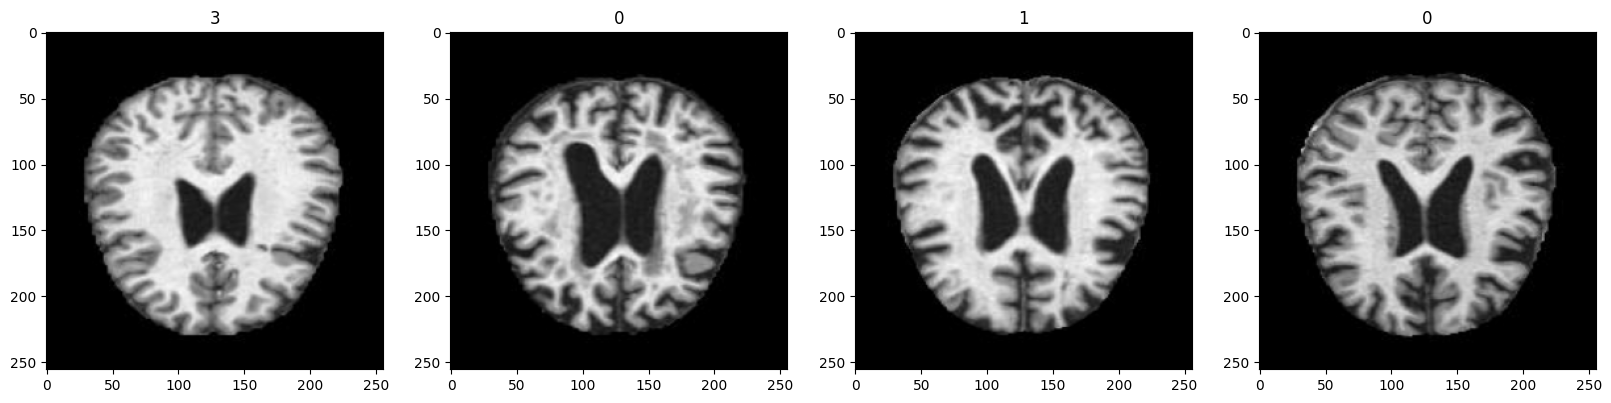

In [557]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [558]:
data = data.map(lambda x,y: (x/255, y))

In [559]:
scaled_iterator= data.as_numpy_iterator()

In [560]:
batch = scaled_iterator.next()

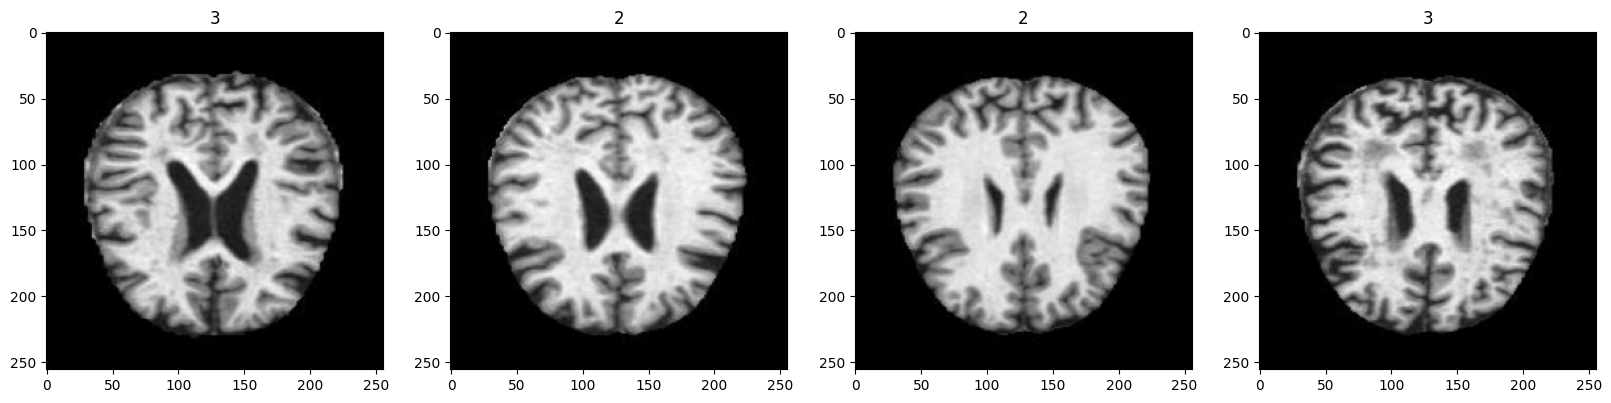

In [561]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [562]:
len(data)

5

In [563]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [564]:
train_size + val_size + test_size

4

In [565]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [83]:
train
#DO NOT EXECUTE CELL BLOCK

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [566]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [567]:
model = Sequential()

In [568]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [583]:
model.compile('ftrl',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
learning_rate = 0.001
#1- ftrl optimizer (batch size: 128); returned accuracy that remained static and did not improve
#2- adam optimizer (batch size: 128); accuracy appears to decrease as training progressed
#3- adagrad optimizer (batch size: 128); accuracy decreased significantly 
#4- adadelta optimizer (batch size: 128); accuracy improved slightly, but loss became erratic
#5- nadam optimizer (batch size: 128); tiny bit better accuracy than ftrl, but accuracy still low
#6- rmsprop optimizer (batch size: 128);accuracy remained in the middle, and loss was no longer smooth
#7- switched back to nadam (batch size: 256); accuracy significantly lowered
#8- nadam (batch size lowered to 32); accuracy improved with lowered batch size
#9- nadam (batch size lowered to 16); accuracy slightly improved with lowered batch size
#10- nadam (batch size lowered to 8); accuracy was very low
#11- nadam (batch size increased back to 16; epoch size increased to 30); accuracy remained very low
#12- ftrl optimizer (batch size: 16, epoch size: 20); accuracy improved, but it was median compared to the val accuracy
#13- ftrl optimizer (batch size: 8, epoch size: 20); accuracy was much higher 
#14- adam optimizer (batch size: 8, epoch size: 20); resulted in loss overfitting and lowered accuracy
#15- ftrl optimizer (batch size: 8, epoch size: 20); possible overfitting of loss but accuracy improved
#16- ftrl optimizer (batch size: 8, epock size: 30); too much accuracy overfitting
#17- nadam (batch size: 8, epoch size: 20);

In [584]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 30, 30, 16)      

# 7. Train

In [585]:
logdir='logs'

In [586]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [587]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])
#rmsprop; batch size= 8; epoch size= 20; learning rate= 0.01
#nadam; batch size= 8; epock size= 20; learning rate= 0.01
#adam; batch size= 8; epoch size= 20; learning rate= 0.01
#ftrl; batch size= 64; epoch size= 20; learning rate= 0.1
#ftrl; batch size= 128; epoch size= 20; learning rate= 0.1
#ftrl; batch size= 128; epoch size= 20; learning rate= 0.01- Best
#ftrl; batch size= 128; epoch size= 20; learning rate= 0.001
#ftrl; batch size= 128; epoch size= 30; learning rate= 0.001- Most alignted accuracy vs loss values
#ftrl; batch size= 128; epoch size= 30; learning rate= 0.0001
#ftrl; batch size= 128; epoch size= 30; learning rate= 0.001
#ftrl; batch size= 128; epoch size= 40; learning rate= 0.001
#ftrl; batch size= 256; epoch size= 40; learning rate= 0.001
#ftrl; batch size= 256; epoch size= 40; learning rate= 0.01
#ftrl; batch size= 256; epoch size= 40; learning rate= 0.001- best

Epoch 1/40


3/3 [==============================] - 16s 5s/step - loss: 0.6437 - accuracy: 0.0104 - val_loss: 0.6435 - val_accuracy: 0.0117
Epoch 2/40
3/3 [==============================] - 15s 5s/step - loss: 0.6439 - accuracy: 0.0065 - val_loss: 0.6436 - val_accuracy: 0.0117
Epoch 3/40
3/3 [==============================] - 16s 6s/step - loss: 0.6423 - accuracy: 0.0104 - val_loss: 0.6399 - val_accuracy: 0.0156
Epoch 4/40
3/3 [==============================] - 17s 6s/step - loss: 0.6408 - accuracy: 0.0078 - val_loss: 0.6390 - val_accuracy: 0.0156
Epoch 5/40
3/3 [==============================] - 18s 6s/step - loss: 0.6404 - accuracy: 0.0091 - val_loss: 0.6382 - val_accuracy: 0.0039
Epoch 6/40
3/3 [==============================] - 15s 5s/step - loss: 0.6377 - accuracy: 0.0052 - val_loss: 0.6350 - val_accuracy: 0.0078
Epoch 7/40
3/3 [==============================] - 15s 5s/step - loss: 0.6369 - accuracy: 0.0078 - val_loss: 0.6369 - val_accuracy: 0.0078
Epoch 8/40
3/3 [=============================

# 8. Plot Performance

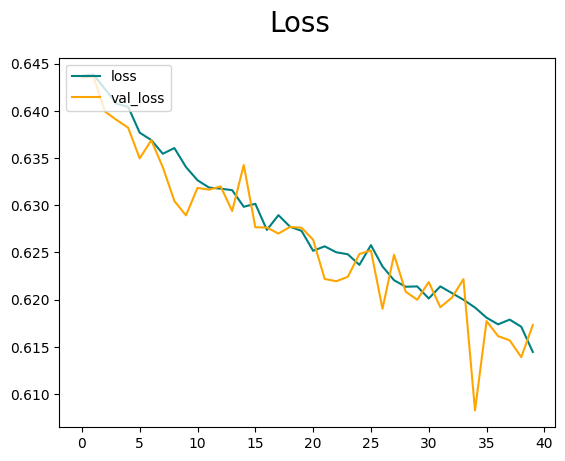

In [597]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

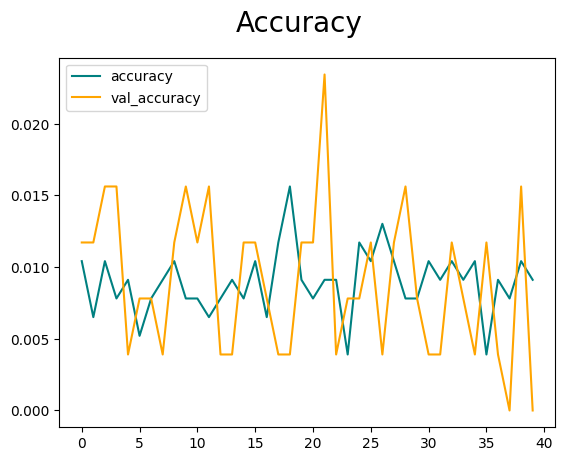

In [598]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [599]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [600]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [601]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [603]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:0.0, Recall: 0.0, Accuracy: 0.0


# 10. Test

In [605]:
import cv2

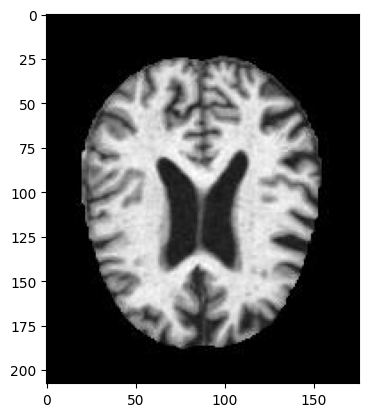

In [608]:
img = cv2.imread('/Users/spangilinan/Documents/GitHub/ImageClassification/test/VeryMildDemented/26 (48).jpg')
plt.imshow(img)
plt.show()

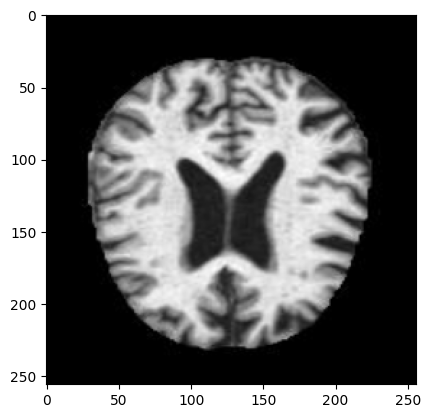

In [609]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [610]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


In [611]:
yhat

array([[0.51233745]], dtype=float32)

In [612]:
if yhat > 0.5: 
    print(f'Predicted class DOES have dementia')
else:
    print(f'Predicted class DOES NOT have dementia')

Predicted class DOES have dementia


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))